In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"
using Muon
using Distances
using StatsPlots
using NewickTreeTools
using Phylo
using SPI
using MAT
using Statistics
using UMAP

In [2]:
pdir = plotsdir("donor_orthogonality")
mkpath(pdir)

"/Users/ben/projects/Doran_etal_2022/plots/donor_orthogonality"

In [3]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))
uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"));

In [4]:
# Match BioBank measurements to column order of UniProt
bbmtx = zeros(size(biobank["oggs"].X, 1), length(uniprot.var_names.vals));
rawidxs = indexin(biobank["oggs"].var_names.vals, uniprot.var_names.vals)
bbmask = .!isnothing.(rawidxs)
uporderedmask = filter(x->.!isnothing(x), rawidxs);
bbmtx[:, uporderedmask] .= biobank["oggs"].X[:, :][:, bbmask];

In [5]:
UPusv = SVD(uniprot.obsm["LSVs"][:, :], uniprot.uns["SVs"][:], uniprot.varm["RSVs"][:, :]');

In [6]:
BBuhat = projectinLSV(bbmtx, UPusv);

## Make M' and M'' and calculate variable OGGs

In [7]:
Mprime_spe = BBuhat[:, 1:90] * diagm(UPusv.S[1:90]) * UPusv.Vt[1:90, :];
Mprime_don = BBuhat[:, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, :];

In [8]:
arespeciesvariable = replace(mapslices(var, Mprime_spe, dims=1)[:] .> 1, true=>"is variable", false=>"is not variable");
aredonor_variable = replace(mapslices(var, Mprime_don, dims=1)[:] .> 1, true=>"is variable", false=>"is not variable");

In [9]:
whichspeciesOGGsarevariable = findall(mapslices(var, Mprime_spe, dims=1)[:] .> 1)
whichdonorOGGsarevariable = findall(mapslices(var, Mprime_don, dims=1)[:] .> 1);

In [10]:
setdiff(whichspeciesOGGsarevariable, whichdonorOGGsarevariable)|>length,
intersect(whichspeciesOGGsarevariable, whichdonorOGGsarevariable)|>length,
setdiff(whichdonorOGGsarevariable, whichspeciesOGGsarevariable)|>length

(129, 296, 177)

In [11]:
129 / 177

0.7288135593220338

## Plot Variable OGG distributions

In [12]:
# groupcolors = ["#B8A57D" "#02A3A3" "#A57DB8"]
groupcolors = ["#B8A57D" :lightgreen]

1×2 Matrix{Any}:
 "#B8A57D"  :lightgreen

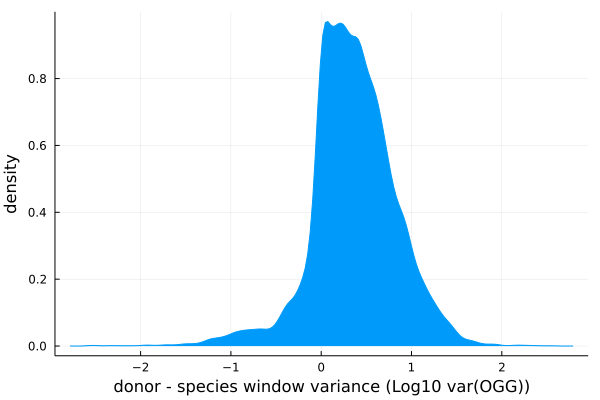

In [13]:
plot(ylabel="density", xlabel="donor - species window variance (Log10 var(OGG))")
density!(log10.(mapslices(var, Mprime_don, dims=1)[:]) .- log10.(mapslices(var, Mprime_spe, dims=1)[:]), fill=0, label="")

In [ ]:
savefig(joinpath(pdir, "donorminusspecieswindow_OGGvariancedistribution.pdf"))

In [14]:
bbmtx[:, sum(bbmtx, dims=1)[:] .> 0]

673×4452 Matrix{Float64}:
 0.0  0.0  1.0  1.0  1.0  0.0  2.0  0.0  …  1.0  0.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  0.0  1.0  0.0  2.0  0.0     1.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  0.0  1.0  0.0  2.0  0.0     1.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  0.0  2.0  0.0     1.0  0.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  2.0  0.0     1.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  2.0  0.0  …  1.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  0.0  2.0  0.0     1.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  0.0  2.0  0.0     1.0  0.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  2.0  0.0     1.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  2.0  0.0     1.0  0.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  1.0  0.0  1.0  0.0  2.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  1.0  0.0  2.0  0.0  

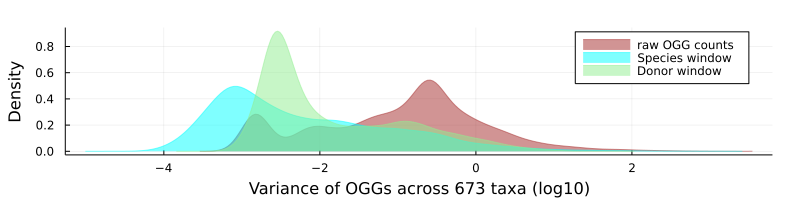

In [15]:
plot(ylabel="Density", xlabel="Variance of OGGs across 673 taxa (log10)", size=(800, 200), margin=5Plots.Measures.mm)
density!(log10.(mapslices(var, bbmtx[:, sum(bbmtx, dims=1)[:] .> 0], dims=1)[:]), fill=0, alpha=.5, c=:brown, label="raw OGG counts")
density!(log10.(mapslices(var, Mprime_spe, dims=1)[:]), fill=0, alpha=.5, c=:aqua, label="Species window")
density!(log10.(mapslices(var, Mprime_don, dims=1)[:]), fill=0, alpha=.5, c=:lightgreen, label="Donor window")


In [29]:
savefig(joinpath(pdir, "donor-compared-to-species-window_OGGvariancedistribution.pdf"))

## Start with Umap Plots

In [16]:
partitions = getintervals(UPusv.S);
# spidists_ogg = calc_spi_mtx(UPusv.V, UPusv.S, partitions);

In [17]:
# matwrite(datadir("exp_pro", "UP7047", "spidists_oggs.mat"), Dict("spimtx"=>spidists_ogg))
spidists_ogg = matread(datadir("exp_pro", "UP7047", "spidists_oggs.mat"))["spimtx"] ./ 7047;

In [18]:
# spiogg_embedding = umap(spidists_ogg, 2; metric=:precomputed, n_epochs=300);
# matwrite(datadir("exp_pro", "UP7047", "spidist_oggs_umap-embedding_nepochs=300.mat"), Dict("embedding"=>spiogg_embedding))
spiogg_embedding = matread(datadir("exp_pro", "UP7047", "spidist_oggs_umap-embedding_nepochs=300.mat"))["embedding"]

2×10177 Matrix{Float64}:
 -1.82359   1.2455    1.18384   1.09181  …  -0.151723  3.40647   4.4615
 -2.77116  -1.41584  -0.81256  -1.30672     -6.58556   0.209896  1.07889

In [19]:
plotlyjs()

Plots.PlotlyJSBackend()

In [20]:
classes = repeat(["Not variable (BioBank)"], size(UPusv.V, 1))
classes[setdiff(whichspeciesOGGsarevariable, whichdonorOGGsarevariable)] .= "Variable in species window"
classes[setdiff(whichdonorOGGsarevariable, whichspeciesOGGsarevariable)] .= "Variable in donor window"
classes[intersect(whichdonorOGGsarevariable, whichspeciesOGGsarevariable)] .= "Variable in both windows";

In [21]:
notunknownOGGs = .!contains.("S", uniprot.var.COG_categories);

In [23]:
windowcolors=["#d8d8d8" "#e283d3" :lightgreen  :aqua];

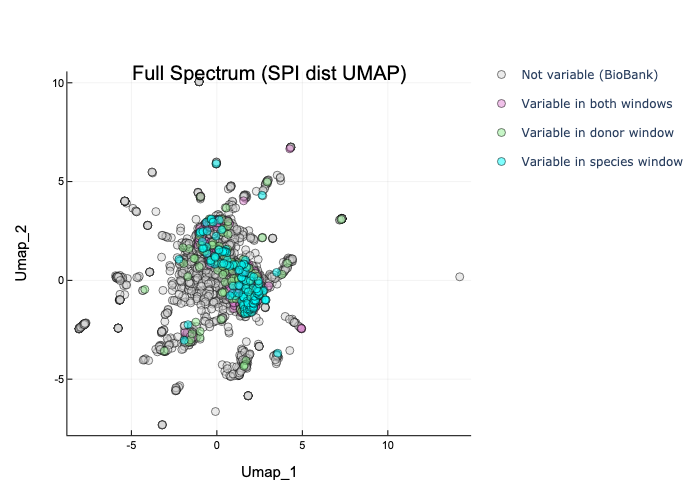

In [24]:
plot(title="Full Spectrum (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_embedding[1, notunknownOGGs], spiogg_embedding[2,notunknownOGGs], 
    size=(900,800),
    # group=uniprot.var.COG_categories,
    # group=arephylumvariable,
    group=classes[notunknownOGGs],
    # marker_z=log10.(mapslices(var, Mprime_don, dims=1)[:]),
    alpha=.5,
    hover=(uniprot.var.og .* ": " .* uniprot.var.description)[notunknownOGGs],
    legend=:outerright,
    c=windowcolors,
    # c=:viridis
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-fullspectrum-knownfunction.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-fullspectrum-knownfunction.html"))

In [ ]:
plot(title="Full Spectrum (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_embedding[1, :], spiogg_embedding[2,:], 
    size=(900,800),
    group=classes,
    alpha=.5,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors,
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-fullspectrum.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-fullspectrum.html"))

In [ ]:
plot(title="Full Spectrum (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_embedding[1, :], spiogg_embedding[2,:], 
    size=(900,800),
    marker_z=log10.(mapslices(var, Mprime_spe, dims=1)[:]),
    alpha=.5,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=:viridis
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-variablilty-fullspectrum.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-variablilty-fullspectrum.html"))

## Donor Window OGG UMAP

In [ ]:
# spiogg_donorwindow = calc_spi_mtx(UPusv.V, UPusv.S, partitions[91:end]);
# spiogg_donorwindow_embedding = umap(spiogg_donorwindow, 2; metric=:precomputed, n_epochs=300);
# matwrite(datadir("exp_pro", "UP7047", "spiogg_donorwindow.mat"), Dict("spimtx"=>spiogg_donorwindow))
# matwrite(datadir("exp_pro", "UP7047", "spiogg_donorwindow_embedding.mat"), Dict("embedding"=>spiogg_donorwindow_embedding))

In [25]:
spiogg_donorwindow = matread(datadir("exp_pro", "UP7047", "spiogg_donorwindow.mat"))["spimtx"]
spiogg_donorwindow_embedding = matread(datadir("exp_pro", "UP7047", "spiogg_donorwindow_embedding.mat"))["embedding"]

2×10177 Matrix{Float64}:
 -2.84417  -2.34971  -2.56216   -2.88696  …  -1.50425  -0.566019   0.611052
  1.93808   1.45273   0.723486   1.93253      0.39087  -1.34484   -1.09795

In [26]:
xlims_don = extrema(spiogg_donorwindow_embedding[1, :]);
ylims_don = extrema(spiogg_donorwindow_embedding[2, :]);
# windowcolors=["#9b9b9b" "#311a77" "#1a7731" "#77311a"];
windowcolors=["#d8d8d8" "#e283d3" :lightgreen  :aqua];

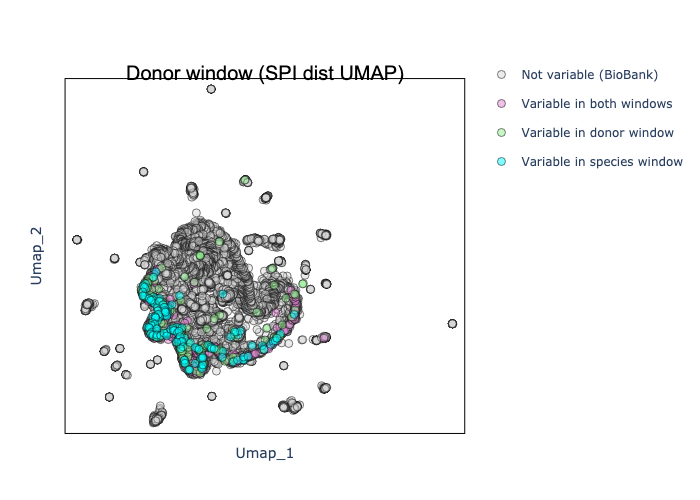

In [27]:
plot(title="Donor window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_donorwindow_embedding[1, :], spiogg_donorwindow_embedding[2,:], 
    size=(950,800),
    group=classes,
    grid=false,
    framestyle=:box,
    ticks=:none,
    tickdirection=:none,
    margin=5Plots.Measures.mm,
    alpha=.5,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors,
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow.html"))

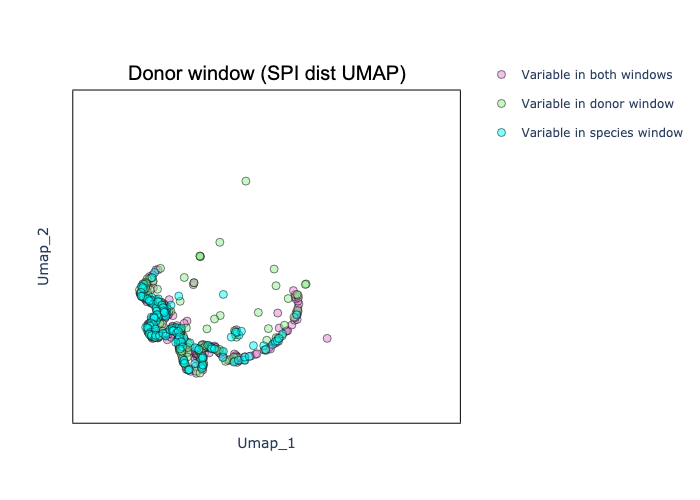

In [28]:
subset_idx = findall(!=("Not variable (BioBank)"), classes)
plot(title="Donor window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
p = scatter!(spiogg_donorwindow_embedding[1, subset_idx], spiogg_donorwindow_embedding[2,subset_idx], 
    size=(635,500),
    group=classes[subset_idx],
    framestyle=:box,
    grid=false,
    ticks=:none,
    tickdirection=:none,
    xlims=xlims_don,
    ylims=ylims_don,
    margin=5Plots.Measures.mm,
    alpha=.5,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors[:, 2:end],
)

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andvariable.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andvariable.html"))

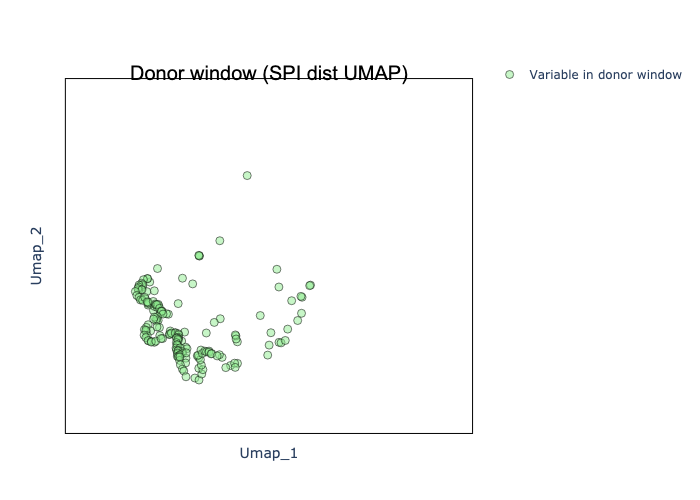

In [29]:
subset_idx = findall(==("Variable in donor window"), classes)
plot(title="Donor window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_donorwindow_embedding[1, subset_idx], spiogg_donorwindow_embedding[2,subset_idx], 
    size=(950,800),
    group=classes[subset_idx],
    grid=false,
    framestyle=:box,
    ticks=:none,
    # ticks=([0], [0]),
    tickdirection=:none,
    margin=5Plots.Measures.mm,
    alpha=.5,
    xlims=xlims_don,
    ylims=ylims_don,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors[:, 3:end],
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andvariableindonorwindow.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andvariableindonorwindow.html"))

In [ ]:
subset_idx = findall(==("Variable in species window"), classes)
plot(title="Donor window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_donorwindow_embedding[1, subset_idx], spiogg_donorwindow_embedding[2,subset_idx], 
    size=(950,800),
    group=classes[subset_idx],
    grid=false,
    framestyle=:box,
    # ticks=([0], [0]),
    ticklabels="",
    tickdirection=:none,
    margin=5Plots.Measures.mm,
    alpha=.5,
    xlims=xlims_don,
    ylims=ylims_don,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors[:, 4:end],
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andvariableinspecieswindow.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andvariableinspecieswindow.html"))

In [ ]:
plot(title="Donor window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_donorwindow_embedding[1, notunknownOGGs], spiogg_donorwindow_embedding[2,notunknownOGGs], 
    size=(900,800),
    group=classes[notunknownOGGs],
    alpha=.5,
    hover=(uniprot.var.og .* ": " .* uniprot.var.description)[notunknownOGGs],
    legend=:outerright,
    c=windowcolors,
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andknownfunction.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-andknownfunction.html"))

In [ ]:
plot(title="Donor window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_donorwindow_embedding[1, :], spiogg_donorwindow_embedding[2,:], 
    size=(900,800),
    marker_z=log10.(mapslices(var, Mprime_spe, dims=1)[:]),
    alpha=.5,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=:viridis,
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-cmapisvarience.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-donorwindow-cmapisvarience.html"))

## Species Window OGG UMAP

In [ ]:
# spiogg_specieswindow = calc_spi_mtx(UPusv.V, UPusv.S, partitions[2:90]);
# spiogg_specieswindow_embedding = umap(spiogg_specieswindow, 2; metric=:precomputed, n_epochs=300);
# matwrite(datadir("exp_pro", "UP7047", "spiogg_specieswindow.mat"), Dict("spimtx"=>spiogg_specieswindow))
# matwrite(datadir("exp_pro", "UP7047", "spiogg_specieswindow_embedding.mat"), Dict("embedding"=>spiogg_specieswindow_embedding))
spiogg_specieswindow = matread(datadir("exp_pro", "UP7047", "spiogg_specieswindow.mat"))["spimtx"]
spiogg_specieswindow_embedding = matread(datadir("exp_pro", "UP7047", "spiogg_specieswindow_embedding.mat"))["embedding"];

In [ ]:
xlims_spe = extrema(spiogg_specieswindow_embedding[1, :]);
ylims_spe = extrema(spiogg_specieswindow_embedding[2, :]);
# windowcolors=["#9b9b9b" "#311a77" "#1a7731" "#77311a"];
windowcolors=["#d8d8d8" "#e283d3" :lightgreen  :aqua];

In [ ]:
plot(title="Species window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_specieswindow_embedding[1, :], spiogg_specieswindow_embedding[2,:], 
    size=(950,800),
    group=classes,
    grid=false,
    framestyle=:box,
    ticks=:none,
    tickdirection=:none,
    margin=5Plots.Measures.mm,
    alpha=.5,
    # xlims=xlims_spe,
    # ylims=ylims_spe,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors,
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow.html"))

In [ ]:
subset_idx = findall(!=("Not variable (BioBank)"), classes)
plot(title="Species window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_specieswindow_embedding[1, subset_idx], spiogg_specieswindow_embedding[2,subset_idx], 
    size=(950,800),
    group=classes[subset_idx],
    grid=false,
    framestyle=:box,
    ticks=:none,
    tickdirection=:none,
    margin=5Plots.Measures.mm,
    alpha=.5,
    xlims=xlims_spe,
    ylims=ylims_spe,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors[:, 2:end],
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andvariable.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andvariable.html"))

In [ ]:
subset_idx = findall(==("Variable in donor window"), classes)
plot(title="Species window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_specieswindow_embedding[1, subset_idx], spiogg_specieswindow_embedding[2,subset_idx], 
    size=(950,800),
    group=classes[subset_idx],
    grid=false,
    framestyle=:box,
    ticks=:none,
    tickdirection=:none,
    margin=5Plots.Measures.mm,
    alpha=.5,
    xlims=xlims_spe,
    ylims=ylims_spe,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors[:, 3:end],
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andvariableindonorwindow.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andvariableindonorwindow.html"))

In [ ]:
subset_idx = findall(==("Variable in species window"), classes)
plot(title="Species window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_specieswindow_embedding[1, subset_idx], spiogg_specieswindow_embedding[2,subset_idx], 
    size=(950,800),
    group=classes[subset_idx],
    grid=false,
    framestyle=:box,
    ticks=:none,
    tickdirection=:none,
    margin=5Plots.Measures.mm,
    alpha=.5,
    xlims=xlims_spe,
    ylims=ylims_spe,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=windowcolors[:, 4:end],
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andvariableinspecieswindow.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andvariableinspecieswindow.html"))

In [ ]:
plot(title="Species window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_specieswindow_embedding[1, notunknownOGGs], spiogg_specieswindow_embedding[2,notunknownOGGs], 
    size=(900,800),
    group=classes[notunknownOGGs],
    alpha=.5,
    hover=(uniprot.var.og .* ": " .* uniprot.var.description)[notunknownOGGs],
    legend=:outerright,
    c=windowcolors,
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andknownfunction.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-andknownfunction.html"))

In [ ]:
plot(title="Species window (SPI dist UMAP)", ylabel="Umap_2", xlabel="Umap_1")
scatter!(spiogg_specieswindow_embedding[1, :], spiogg_specieswindow_embedding[2,:], 
    size=(900,800),
    marker_z=log10.(mapslices(var, Mprime_spe, dims=1)[:]),
    alpha=.5,
    hover=uniprot.var.og .* ": " .* uniprot.var.description,
    legend=:outerright,
    c=:viridis
    )

In [ ]:
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-cmapisvarience.pdf"))
savefig(joinpath(pdir, "SPIoggUMAP-specieswindow-cmapisvarience.html"))

## Plot variable OGGs

In [30]:
windowcolors=["#9b9b9b" "#77311a" "#1a7731"]

1×3 Matrix{String}:
 "#9b9b9b"  "#77311a"  "#1a7731"

In [31]:
allVariableOGGs = vcat(
     setdiff(whichspeciesOGGsarevariable, whichdonorOGGsarevariable),
     intersect(whichdonorOGGsarevariable, whichspeciesOGGsarevariable),
     setdiff(whichdonorOGGsarevariable, whichspeciesOGGsarevariable),
     );

In [32]:
(
setdiff(whichspeciesOGGsarevariable, whichdonorOGGsarevariable)|>length,
intersect(whichdonorOGGsarevariable, whichspeciesOGGsarevariable)|>length,
setdiff(whichdonorOGGsarevariable, whichspeciesOGGsarevariable)|>length,
)

(129, 296, 177)

In [33]:
spe_only = setdiff(whichspeciesOGGsarevariable, whichdonorOGGsarevariable)
sp_n_don = intersect(whichdonorOGGsarevariable, whichspeciesOGGsarevariable)
don_only = setdiff(whichdonorOGGsarevariable, whichspeciesOGGsarevariable);

In [34]:
plt_spe_var = hcat(
    mapslices(var, bbmtx[:, spe_only], dims=1)[:],
    mapslices(var, Mprime_spe[:, spe_only], dims=1)[:],
    mapslices(var, Mprime_don[:, spe_only], dims=1)[:],
);
plt_bth_var = hcat(
    mapslices(var, bbmtx[:, sp_n_don], dims=1)[:],
    mapslices(var, Mprime_spe[:, sp_n_don], dims=1)[:],
    mapslices(var, Mprime_don[:, sp_n_don], dims=1)[:],
);
plt_don_var = hcat(
    mapslices(var, bbmtx[:, don_only], dims=1)[:],
    mapslices(var, Mprime_spe[:, don_only], dims=1)[:],
    mapslices(var, Mprime_don[:, don_only], dims=1)[:],
);

In [ ]:
plot(log10.(plt_spe_var[sortperm(plt_spe_var[:, 1]), :]), 
    title="variance order for species only OGGs",
    legend=:topleft,
    ylims=(-3,3),
    labels=["raw OGG counts" "M' Species window" "M'' Donor window"],
    c=windowcolors
    )

In [ ]:
savefig(joinpath(pdir, "variance-order-for-species-only-OGGs.pdf"))

In [ ]:
plot(log10.(plt_bth_var[sortperm(plt_bth_var[:, 1]), :]), 
    title="variance order for variable in both window OGGs",
    ylims=(-3,3),
    legend=:topleft,
    labels=["raw OGG counts" "M' Species window" "M'' Donor window"],
    c=windowcolors,
)

In [ ]:
savefig(joinpath(pdir, "variance-order-for-variable-in-both-window-OGGs.pdf"))

In [ ]:
plot(log10.(plt_don_var[sortperm(plt_don_var[:, 1]), :]), 
    title="variance order for donor only OGGs",
    legend=:topleft,
    ylims=(-3,3),
    labels=["raw OGG counts" "M' Species window" "M'' Donor window"],
    c=windowcolors
)

In [ ]:
savefig(joinpath(pdir, "variance-order-for-donor-only-OGGs.pdf"))

In [36]:
allVariableOGGs = vcat(
     spe_only[sortperm(plt_spe_var[:, 1])],
     sp_n_don[sortperm(plt_bth_var[:, 1])],
     don_only[sortperm(plt_don_var[:, 1])],
     );

pltvarforvarOGGs = hcat(
     mapslices(var, bbmtx[:, allVariableOGGs], dims=1)[:],
     mapslices(var, Mprime_spe[:, allVariableOGGs], dims=1)[:],
     mapslices(var, Mprime_don[:, allVariableOGGs], dims=1)[:],
);

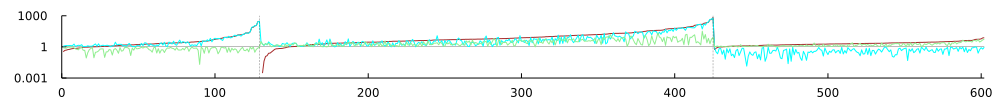

In [40]:
plot( # title="Variance of OGGs"
    size=(1000, 100),
    grid=false,
    ylims=(-3,3),
    xlims=(0, size(pltvarforvarOGGs,1)),
    yticks=([-3, 0, 3], ["0.001", "1", "1000"]),
    legend=:none,
    margin=2Plots.Measures.mm,
)
hline!([0], c=:black, lw=0.25)
plot!(log10.(pltvarforvarOGGs),
    labels=["raw OGG counts" "M' Species window" "M'' Donor window"],
    c=[:brown :aqua :lightgreen],
)
vline!([length(spe_only), length(spe_only)+length(sp_n_don)], c=:black, linestyle=:dash, lw=.25)

In [41]:
savefig(joinpath(pdir, "variance-order-for-all673taxa-variable-OGGs.pdf"))

## Count Heatmaps

In [ ]:
sporder = sortperm(biobank.obs.species);

In [ ]:
spedondf = biobank.obs[:, [:phylum, :class, :order, :family, :genus, :species, :donor]] |>
    df->sort(df, [:phylum, :class, :order, :family, :genus, :species, :donor]) |>
    df->df[:, [:species, :donor]];

In [ ]:
roworder = biobank.obs[:, [:phylum, :class, :order, :family, :genus, :species, :donor]] |>
    df->sortperm(df, [:phylum, :class, :order, :family, :genus, :species, :donor]);

In [ ]:
r_idxs = occursin.("luti", biobank.obs.species) |> findall
b_idxs = occursin.("uniformis", biobank.obs.species) |> findall;
# popat!(b_vulgatus_idxs, occursin.("MSK.7.24", biobank.obs_names[b_vulgatus_idxs]) |> findfirst)
donorid = biobank.obs_names |>
    v -> split.(v, ".") |>
    v -> getindex.(v, 2) |>
    v -> parse.(Int,v)

b_idxs = b_idxs[sortperm(donorid[b_idxs])]
r_idxs = r_idxs[sortperm(donorid[r_idxs])]

luti_uniformis_idxs = union(b_idxs,  r_idxs);

In [ ]:
clims = bbmtx[roworder, allVariableOGGs] |> extrema |> x->abs.(x) |> maximum |> x-> (-x, x)

In [ ]:
heatmap(bbmtx[roworder, allVariableOGGs], c=:bwr, clims=clims, size=(1200,300))
vline!([129, 296+129].+0.5, lw=.5, c=:black, label="")

In [ ]:
savefig(joinpath(pdir, "heatmap_rawOGG_variableOGGsinspeciesordonorwindow.pdf"))

In [ ]:
heatmap(bbmtx[luti_uniformis_idxs, allVariableOGGs], c=:bwr, clims=clims, size=(1200,300))
vline!([129, 296+129].+0.5, lw=.5, c=:black, label="")

In [ ]:
savefig(joinpath(pdir, "heatmap_rawOGG_lutianduniformis_variableOGGsinspeciesordonorwindow.pdf"))

In [ ]:
clims_spe = Mprime_spe[roworder, allVariableOGGs] |> extrema |> x->abs.(x) |> maximum |> x-> (-x, x)

In [ ]:
heatmap(Mprime_spe[roworder, allVariableOGGs], c=:bwr, clims=clims_spe, size=(1200,300))
vline!([129, 296+129].+0.5, lw=.5, c=:black, label="")

In [ ]:
savefig(joinpath(pdir, "heatmap_specieswindowOGG_variableOGGsinspeciesordonorwindow.pdf"))

In [ ]:
heatmap(Mprime_spe[luti_uniformis_idxs, allVariableOGGs], c=:bwr, clims=clims_spe, size=(1200,300))
vline!([129, 296+129].+0.5, lw=.5, c=:black, label="")

In [ ]:
savefig(joinpath(pdir, "heatmap_specieswindowOGG_lutianduniformis_variableOGGsinspeciesordonorwindow.pdf"))

In [ ]:
clims_don = Mprime_don[roworder, allVariableOGGs] |> extrema |> x->abs.(x) |> maximum |> x-> (-x, x)

In [ ]:
heatmap(Mprime_don[roworder, allVariableOGGs], c=:bwr, clims=clims_don, size=(1200,300))
vline!([129, 296+129].+0.5, lw=.5, c=:black, label="")

In [ ]:
savefig(joinpath(pdir, "heatmap_donorwindowOGG_variableOGGsinspeciesordonorwindow.pdf"))

In [ ]:
heatmap(Mprime_don[luti_uniformis_idxs, allVariableOGGs], c=:bwr, clims=clims_don, size=(1200,300))
vline!([129, 296+129].+0.5, lw=.5, c=:black, label="")

In [ ]:
savefig(joinpath(pdir, "heatmap_donorwindowOGG_lutianduniformis_variableOGGsinspeciesordonorwindow.pdf"))

## Species & Donor Heatmap

In [ ]:
spedondf = biobank.obs[:, [:phylum, :class, :order, :family, :genus, :species, :donor]] |>
    df->sort(df, [:phylum, :class, :order, :family, :genus, :species, :donor]) |>
    df->df[:, [:species, :donor]];

In [ ]:
heatmap(Matrix(spedondf), c=:glasbey_hv_n256)

In [ ]:
pdir

In [ ]:
savefig(joinpath(pdir, "SpeciesDonor_heatmap_full.pdf"))

## Chi Sq tests for difference of function

In [ ]:
using FreqTables
using HypothesisTests
using MultipleTesting

In [ ]:
props = freqtable(uniprot.var.COG_categories, classes);

In [ ]:
propsdf = hcat(DataFrame("categories"=>props.dicts[1]|>names), DataFrame(props.array, props.dicts[2]|>names));

In [ ]:
pltdf = propsdf[findall((propsdf[:, 4] .> 0) .|| (propsdf[:, 5] .> 0)), :]

In [ ]:
thetas = vec(sum(Matrix(pltdf[:, [5,4]]), dims=1)./sum(Matrix(pltdf[:, [5,4]])))

In [ ]:
Matrix(pltdf[[1], [5,4]])[:]

In [ ]:
fieldnames(typeof(ChisqTest([8, 18], thetas)))

In [ ]:
ChisqTest([8, 18], thetas)

In [ ]:
0.05 / 31

In [ ]:
pvals = mapslices(Matrix(pltdf[:, [5,4]]), dims=2) do row
    pvalue(ChisqTest(row, thetas))
end[:]
pvals_bonferroni = adjust(pvals, Bonferroni())
pvals_bh = adjust(pvals, BenjaminiHochberg());

In [ ]:
pltdf.categories[pvals_bonferroni]

In [ ]:
plot(yticks=(1:nrow(pltdf), pltdf.categories),
     xticks=(1:2, names(pltdf)[[5,4]]),
     tickdirection=:out)
heatmap!(Matrix(pltdf[:, [5,4]]), c=:grayC)